In [65]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [66]:

# Load and preprocess data
def load_and_preprocess_data(folder):
    dfs = []
    for i in range(9, 16):
        file_name = f"HTOL-{i:02d}_alerts.csv"
        df = pd.read_csv(os.path.join(folder, file_name))
        df['machine_id'] = f'HTOL-{i:02d}'
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df['Time'] = pd.to_datetime(combined_df['Time'])
    combined_df = combined_df.sort_values(['machine_id', 'Time'])

    return combined_df

In [67]:

# Feature engineering
def engineer_features(df):
    df['hour'] = df['Time'].dt.hour
    df['day_of_week'] = df['Time'].dt.dayofweek
    df['month'] = df['Time'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Calculate rolling statistics
    df['rolling_mean'] = df.groupby('machine_id')['ChlPrs'].rolling(window=24, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_std'] = df.groupby('machine_id')['ChlPrs'].rolling(window=24, min_periods=1).std().reset_index(0, drop=True)

    # Calculate time since last alert for each type
    alert_types = ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']
    for alert_type in alert_types:
        df[f'time_since_{alert_type}'] = df.groupby('machine_id').apply(lambda x: x['Time'] - x[x['ALERT'] == alert_type]['Time'].shift(1)).reset_index(level=0, drop=True)
        df[f'time_since_{alert_type}'] = df[f'time_since_{alert_type}'].dt.total_seconds() / 3600  # Convert to hours

    return df

In [68]:

def prepare_data_for_classification(df, target_alert_type, prediction_window):
    df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)

    features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']]
    X = df[features]
    y = df['target'].fillna(0)  # Fill NaN with 0 (no alert)

    return X, y

In [69]:

def train_and_evaluate_classifier(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # XGBoost configuration for imbalanced classification
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
        random_state=42,
        eval_metric='logloss',
        early_stopping_rounds=10,
    )

    # Train with early stopping
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=0
    )

    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

    # Calculate precision, recall, and F1-score with 'weighted' averaging
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Print feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)

    return model, scaler

In [70]:

def visualize_alerts_efficient(df, model, scaler, target_alert_type, prediction_window, probability_threshold=0.7):
    features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']]
    X = df[features]
    X_scaled = scaler.transform(X)

    df['alert_probability'] = model.predict_proba(X_scaled)[:, 1]
    df['high_risk'] = df['alert_probability'] > probability_threshold

    plt.figure(figsize=(20, 15))
    machines = df['machine_id'].unique()
    n_machines = len(machines)

    for i, machine_id in enumerate(machines):
        machine_df = df[df['machine_id'] == machine_id]

        # Plot actual alerts
        alerts = machine_df[machine_df['ALERT'] == target_alert_type]
        plt.scatter(alerts['Time'], [i-0.2] * len(alerts), marker='o', s=100, label=f'Actual {target_alert_type} Alert' if i == 0 else "")

        # Plot high-risk periods
        high_risk_periods = machine_df[machine_df['high_risk']]
        plt.scatter(high_risk_periods['Time'], [i+0.2] * len(high_risk_periods), marker='x', s=100, label=f'High Risk Period ({target_alert_type})' if i == 0 else "")

        plt.text(df['Time'].min(), i, machine_id, va='center', ha='right', fontweight='bold')

    plt.yticks(range(n_machines), [""] * n_machines)
    plt.xlabel('Date')
    plt.ylabel('Machine ID')
    plt.title(f'Actual Alerts vs High Risk Periods for {target_alert_type} Alerts')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_38179/670758071.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'time_since_{alert_type}'] = df.groupby('machine_id').apply(lambda x: x['Time'] - x[x['ALERT'] == alert_type]['Time'].shift(1)).reset_index(level=0, drop=True)
/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_38179/670758071.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w


Training model for LOW alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_38179/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93    265420
         1.0       0.01      0.83      0.02       521

    accuracy                           0.86    265941
   macro avg       0.51      0.85      0.47    265941
weighted avg       1.00      0.86      0.92    265941

Precision: 0.9977
Recall: 0.8620
F1-score: 0.9240

Feature Importance:
              feature  importance
7      time_since_LOW    0.336130
0              ChlPrs    0.179224
3               month    0.134362
5        rolling_mean    0.120802
1                hour    0.102835
6         rolling_std    0.065669
2         day_of_week    0.060978
4          is_weekend    0.000000
8   time_since_MEDIUM    0.000000
9     time_since_HIGH    0.000000
10   time_since_SIGMA    0.000000


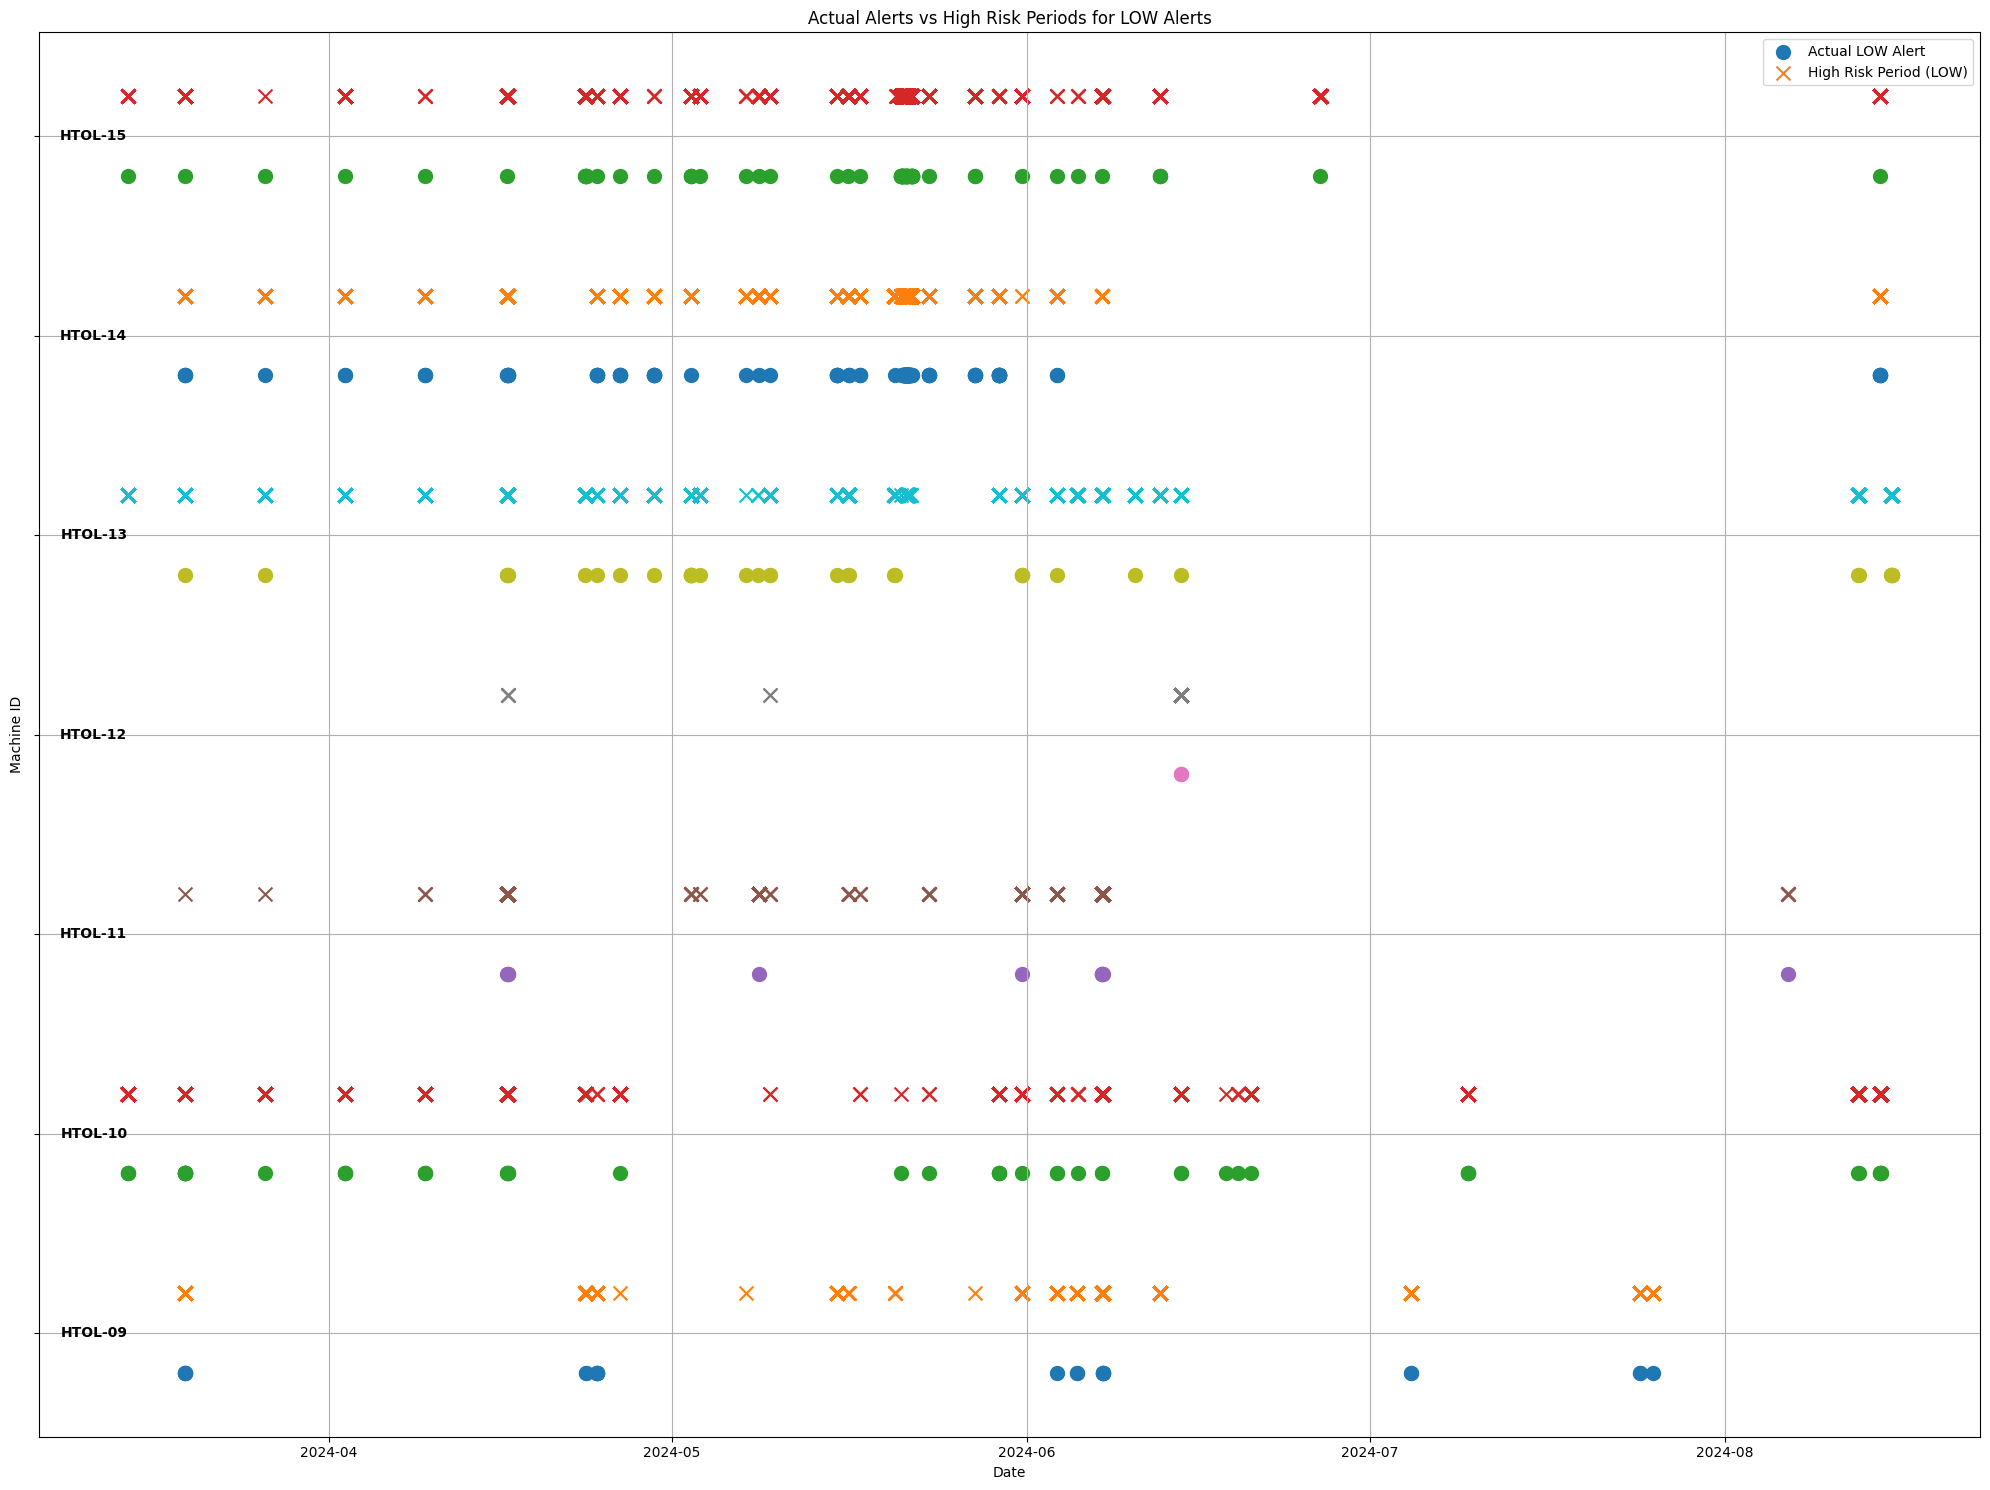


Training model for MEDIUM alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_38179/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    265918
         1.0       0.06      0.96      0.11        23

    accuracy                           1.00    265941
   macro avg       0.53      0.98      0.55    265941
weighted avg       1.00      1.00      1.00    265941

Precision: 0.9999
Recall: 0.9986
F1-score: 0.9992

Feature Importance:
              feature  importance
0              ChlPrs    0.656051
5        rolling_mean    0.240048
2         day_of_week    0.049750
6         rolling_std    0.024006
1                hour    0.014526
8   time_since_MEDIUM    0.008447
3               month    0.007141
10   time_since_SIGMA    0.000030
4          is_weekend    0.000000
7      time_since_LOW    0.000000
9     time_since_HIGH    0.000000


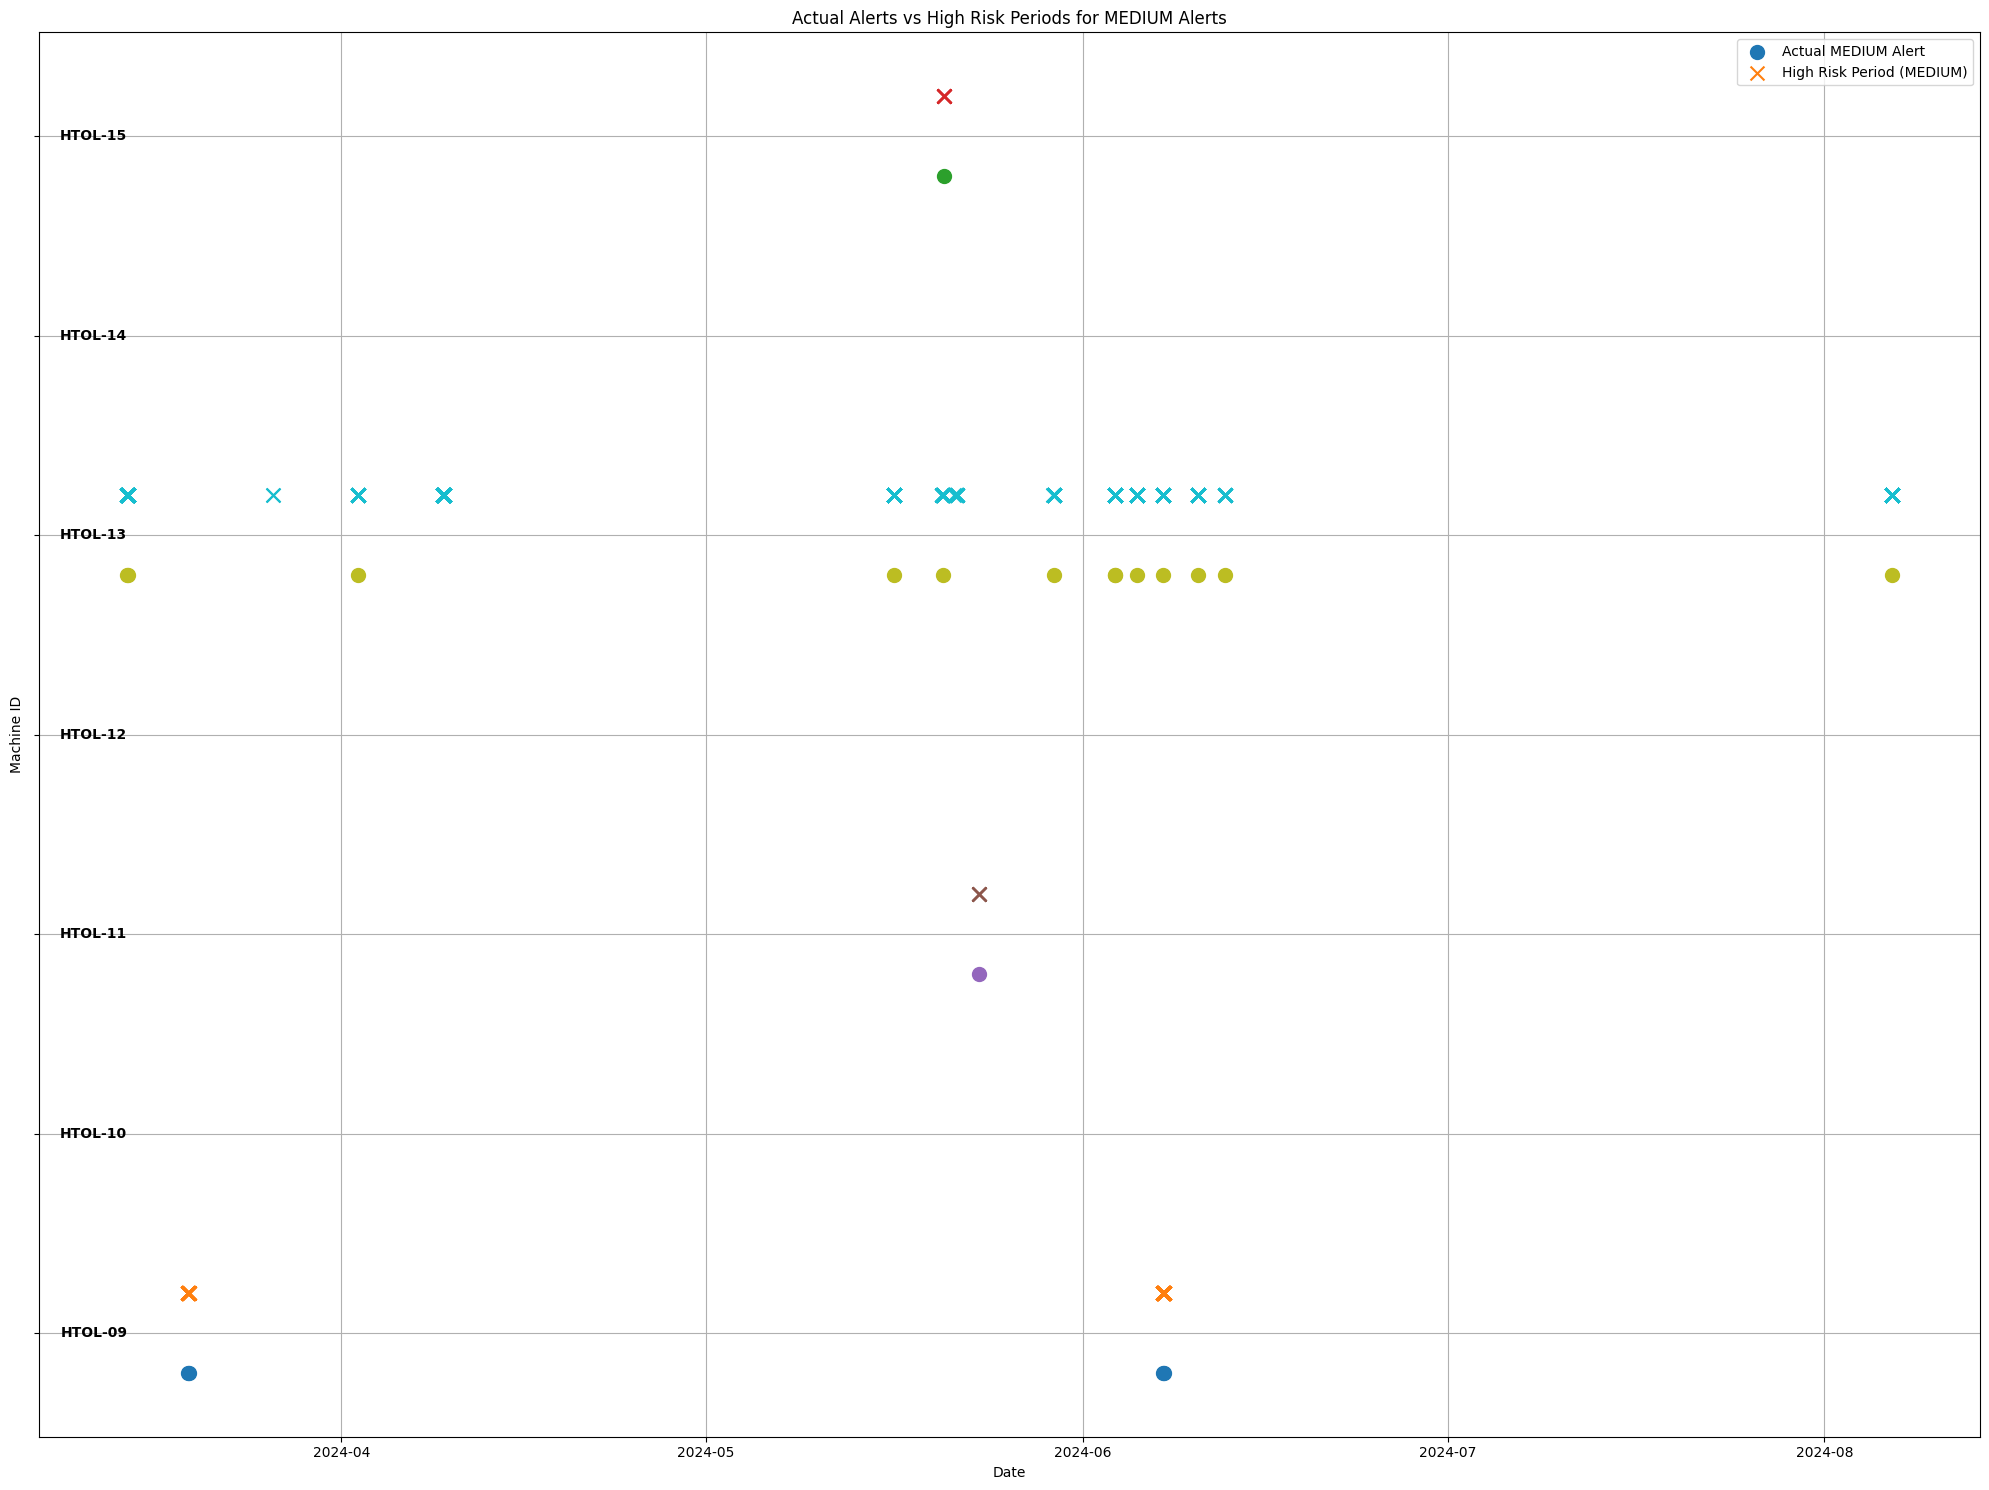


Training model for HIGH alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_38179/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    265931
         1.0       0.00      0.40      0.01        10

    accuracy                           1.00    265941
   macro avg       0.50      0.70      0.50    265941
weighted avg       1.00      1.00      1.00    265941

Precision: 0.9999
Recall: 0.9967
F1-score: 0.9983

Feature Importance:
              feature  importance
0              ChlPrs    0.533075
6         rolling_std    0.196321
5        rolling_mean    0.169618
9     time_since_HIGH    0.039608
3               month    0.023515
1                hour    0.020999
2         day_of_week    0.016865
4          is_weekend    0.000000
7      time_since_LOW    0.000000
8   time_since_MEDIUM    0.000000
10   time_since_SIGMA    0.000000


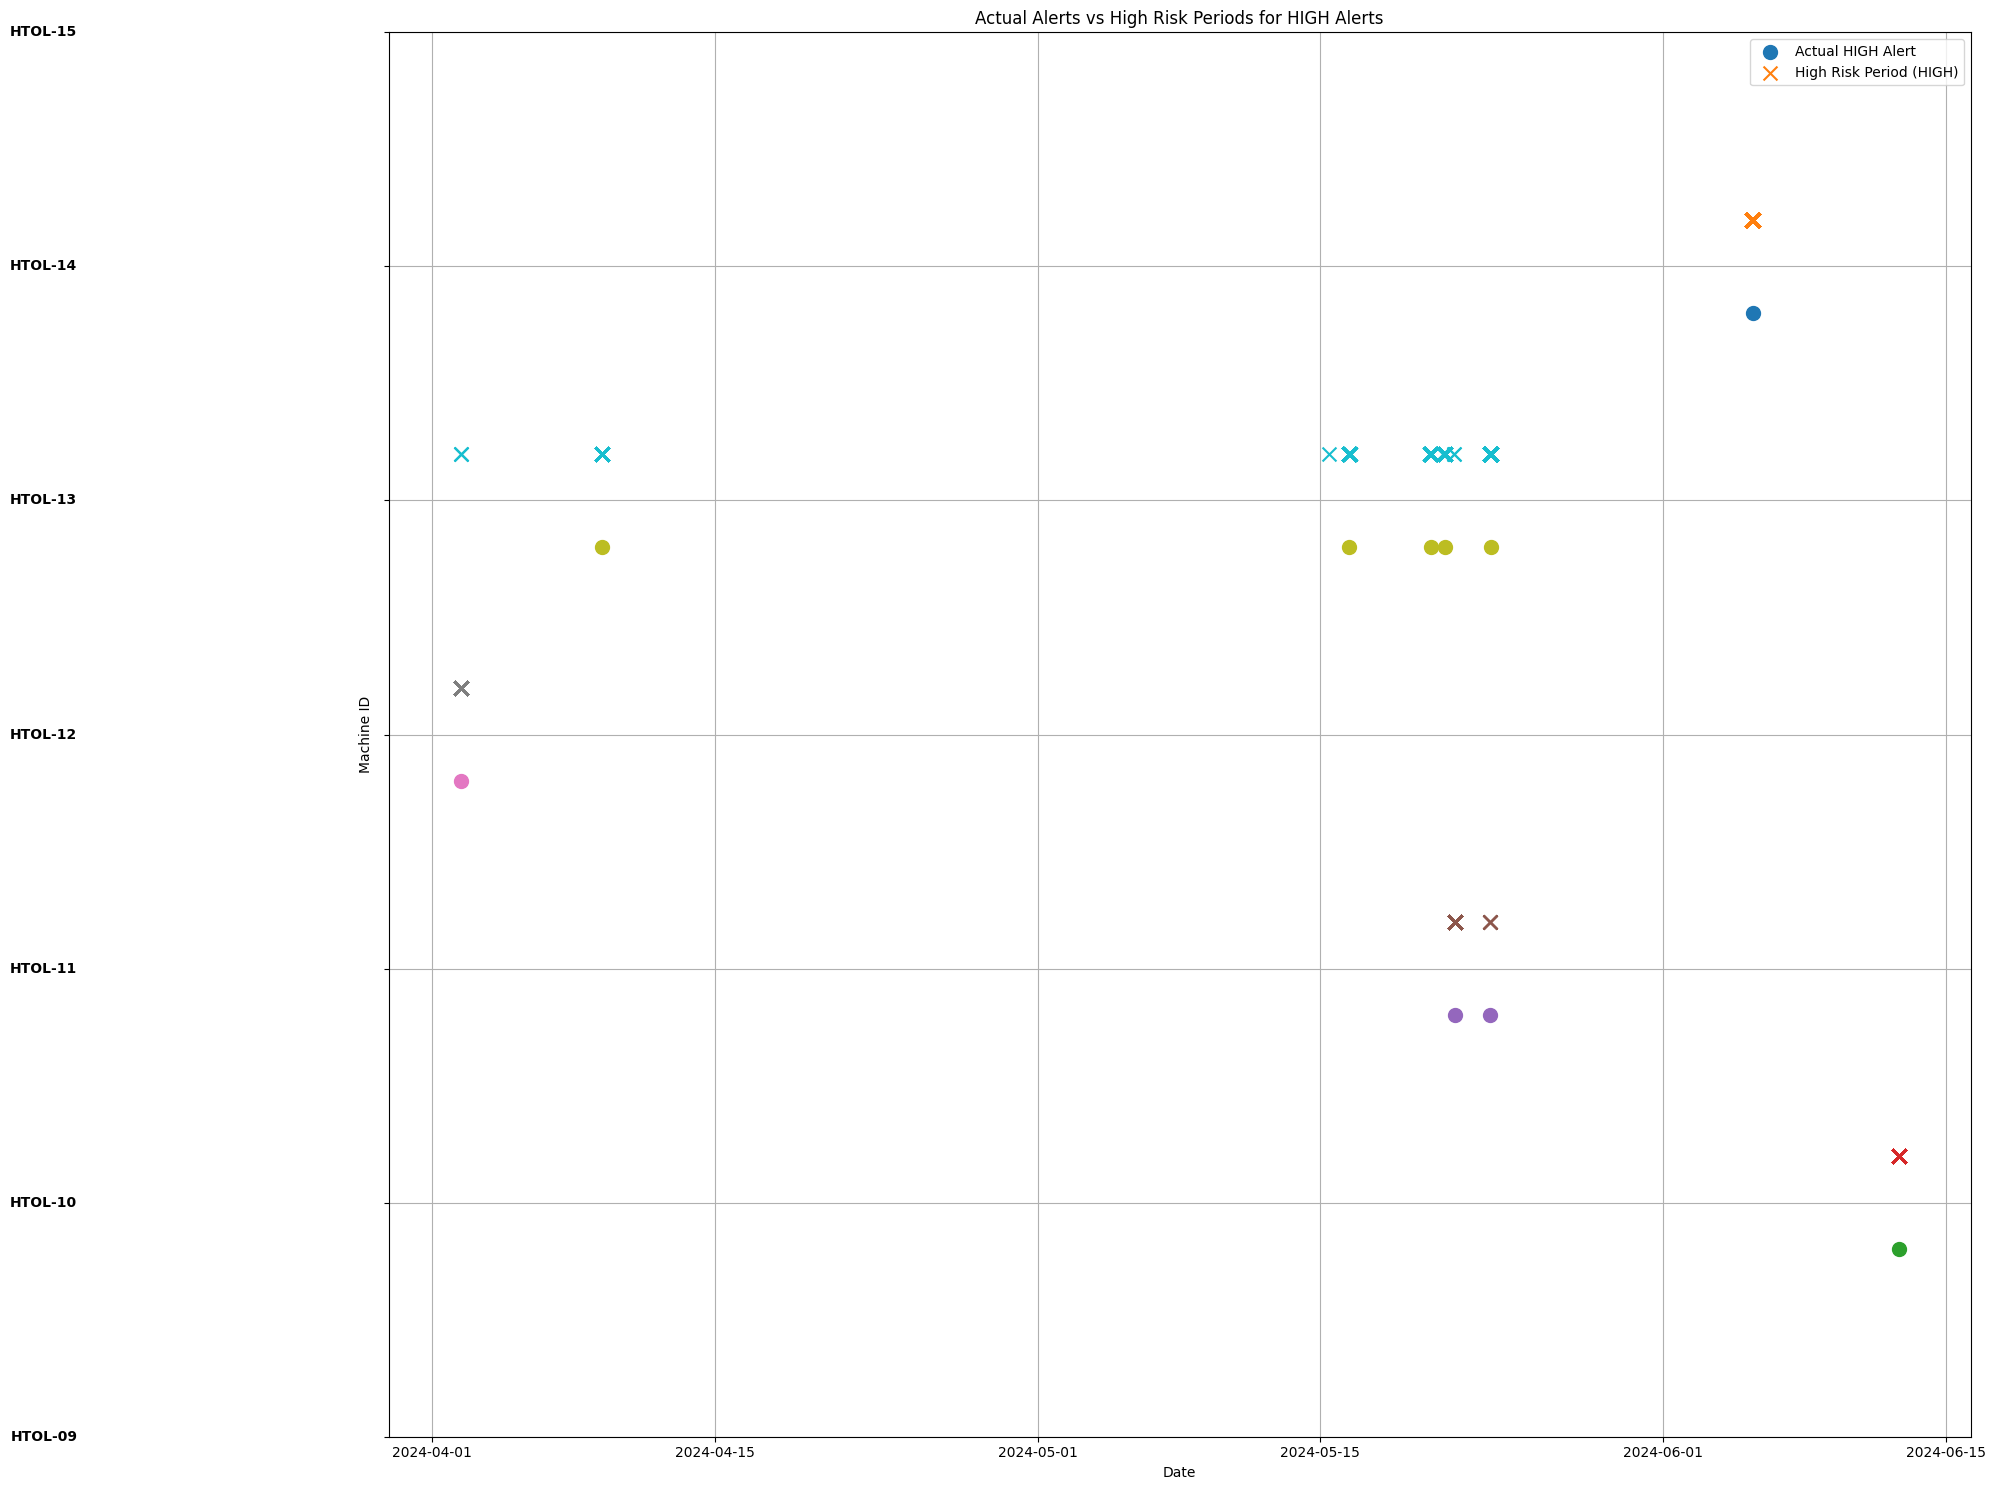


Training model for SIGMA alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_38179/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    265921
         1.0       0.02      0.75      0.04        20

    accuracy                           1.00    265941
   macro avg       0.51      0.87      0.52    265941
weighted avg       1.00      1.00      1.00    265941

Precision: 0.9999
Recall: 0.9972
F1-score: 0.9985

Feature Importance:
              feature  importance
5        rolling_mean    0.216110
0              ChlPrs    0.204585
3               month    0.176493
10   time_since_SIGMA    0.122415
6         rolling_std    0.118040
1                hour    0.099523
2         day_of_week    0.062834
4          is_weekend    0.000000
7      time_since_LOW    0.000000
8   time_since_MEDIUM    0.000000
9     time_since_HIGH    0.000000


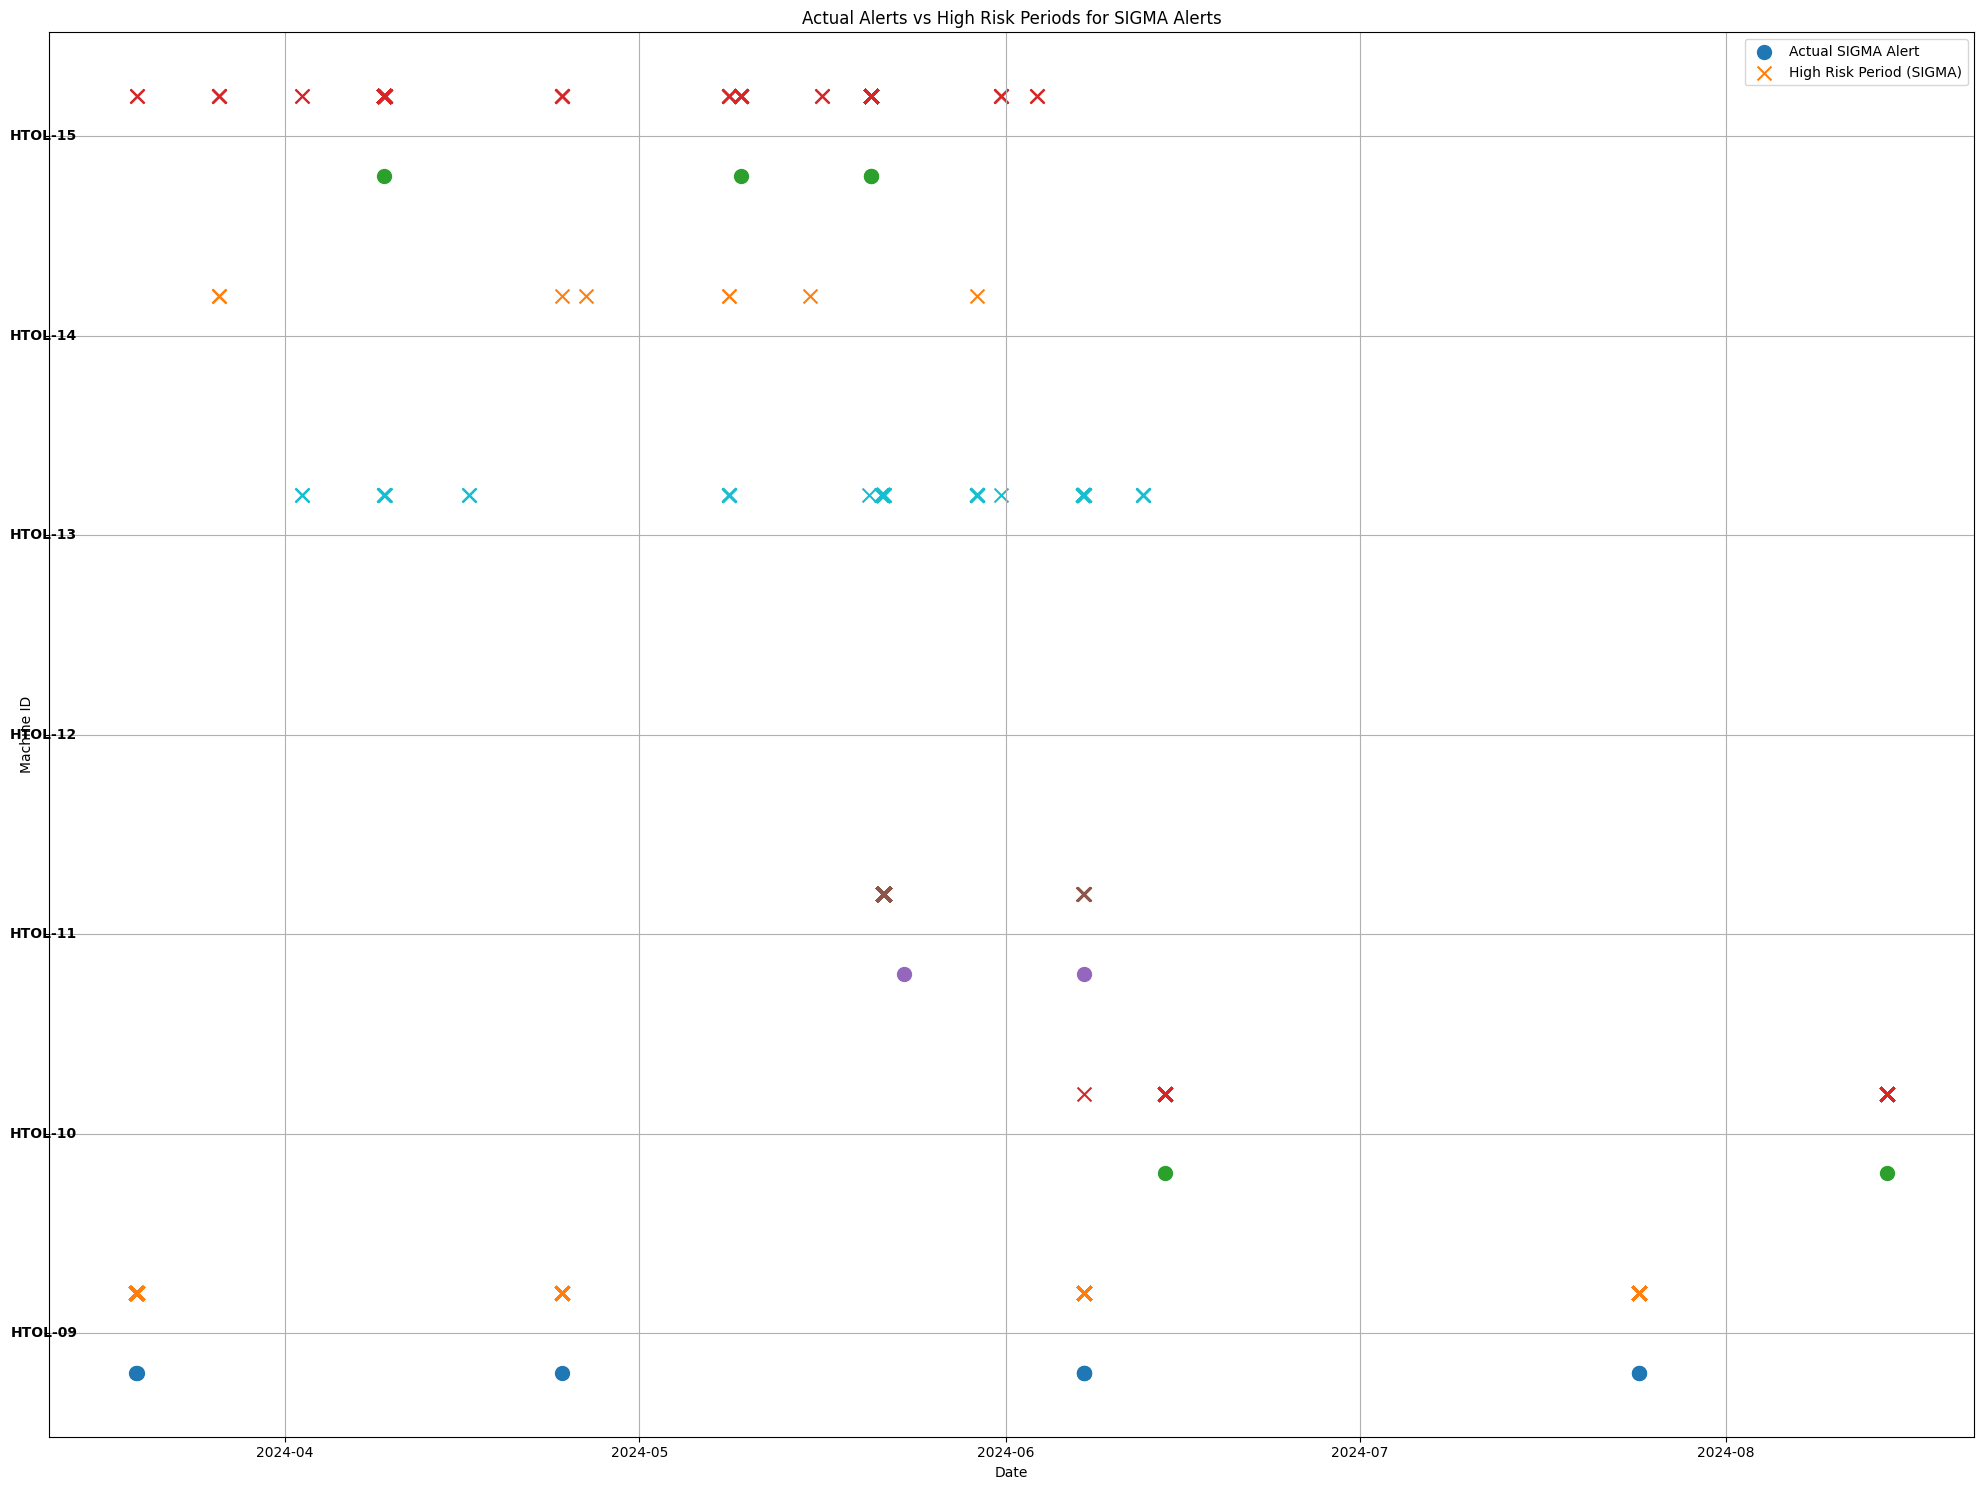

Probability of LOW alert in the next 7 days: 0.16
Probability of MEDIUM alert in the next 7 days: 0.00
Probability of HIGH alert in the next 7 days: 0.00
Probability of SIGMA alert in the next 7 days: 0.00


In [71]:
if True:
    folder = "../../../outlier_tolerance=5_grouping_time_window=200_anomaly_threshold=6_start_date=2022-01-01_end_date=2026-01-01"
    prediction_window = 7  # days
    probability_threshold = 0.7  # Adjust this value to balance between over-prediction and missed alerts

    df = load_and_preprocess_data(folder)
    df = engineer_features(df)

    alert_types = ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']
    models = {}
    scalers = {}

    for alert_type in alert_types:
        print(f"\nTraining model for {alert_type} alerts:")
        X, y = prepare_data_for_classification(df, alert_type, prediction_window)
        model, scaler = train_and_evaluate_classifier(X, y)
        models[alert_type] = model
        scalers[alert_type] = scaler

        visualize_alerts_efficient(df, model, scaler, alert_type, prediction_window, probability_threshold)

    # Example of making predictions for new data
    new_data = df.iloc[-1:].copy()  # Use the last row as an example
    for alert_type in alert_types:
        features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in alert_types]
        X_new = new_data[features]
        X_new_scaled = scalers[alert_type].transform(X_new)
        alert_probability = models[alert_type].predict_proba(X_new_scaled)[0, 1]
        print(f"Probability of {alert_type} alert in the next {prediction_window} days: {alert_probability:.2f}")